# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

[ 0.02156203 -0.02075483  0.00115636 -0.04412801]


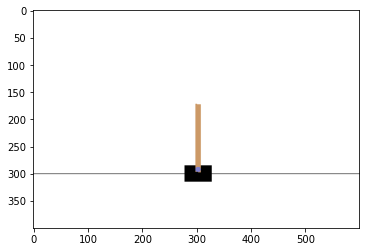

In [3]:
# env_name = 'LunarLander-v2'
env_name = 'CartPole-v1'
env = gym.make(env_name)

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

print(env.reset())
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
hidden = 64

policy_model = nn.Sequential(
    torch.nn.Linear(state_dim[0], hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, n_actions)
)
value_model = nn.Sequential(
    torch.nn.Linear(state_dim[0], hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, 1),
    torch.nn.Flatten(start_dim=0)
)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [6]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    states = torch.Tensor(states)
    with torch.no_grad():
        logits = policy_model(states)
        probs = F.softmax(logits, dim=-1).numpy()
        
    # convert states, compute logits, use softmax to get probability
    return probs

In [10]:
def predict_v(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    states = torch.Tensor(states)
    with torch.no_grad():
        v = value_model(states).numpy()
        
    return v

In [11]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_probs( test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

In [12]:
s = env.reset()
a = predict_probs([s,s])
v = predict_v( [s, s])
a, v

(array([[0.5370548 , 0.46294525],
        [0.5370548 , 0.46294525]], dtype=float32),
 array([0.02337, 0.02337], dtype=float32))

### Play the game

We can now use our newly built agent to play the game.

In [17]:
def generate_session(env,  t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
#         action_probs = predict_probs(model, np.array([s]))[0]

        # Sample action with given probabilities.
        probs = predict_probs([s])[0]
        a = np.random.choice(np.arange(n_actions), p=probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [18]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [19]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    def reward_to_go(rewards):
        rewards = np.flip(rewards)
        reward_sum =0
        for reward in rewards:
            reward_sum = gamma*reward_sum + reward
            yield reward_sum
            
    return np.flip(np.fromiter(reward_to_go(rewards), dtype=float))

In [20]:
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [21]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

<h3>What is the meaning of parameter -1?</h3>
<p>If there is any situation that you don't know how many rows you want but are sure of the number of columns, then you can specify this with a -1. (<em>Note that you can extend this to tensors with more dimensions. Only one of the axis value can be -1</em>). This is a way of telling the library: "give me a tensor that has these many columns and you compute the appropriate number of rows that is necessary to make this happen".</p>

<p>"autocompute"</p>

In [22]:
index = torch.tensor([[0], 
                      [3],
                      [2]])
torch.zeros(3, 4, dtype=float).scatter_(1, index, 1)

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=torch.float64)

In [24]:
states, actions, rewards = generate_session(env)
actions = torch.tensor(actions[:3], dtype=torch.int32).detach()
print('actions = \n', actions)
actions = actions.view(-1, 1)
print('actions =\n',actions)
one_hot_zeros = torch.zeros(actions.size()[0], n_actions)
print('zeros = \n', one_hot_zeros)
one_hot_zeros.scatter_(1, actions.type(torch.LongTensor), 1)
print('one_hot_zeros= \n',one_hot_zeros)
print(to_one_hot(actions, n_actions))

actions = 
 tensor([1, 0, 0], dtype=torch.int32)
actions =
 tensor([[1],
        [0],
        [0]], dtype=torch.int32)
zeros = 
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
one_hot_zeros= 
 tensor([[0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.]])


In [29]:
# Your code: define optimizers
p_optimizer = torch.optim.Adam(policy_model.parameters(), 1e-3)
v_optimizer = torch.optim.Adam(value_model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    
    values = value_model(states)
    v_loss = torch.mean( (values - cumulative_returns)**2 )
    v_loss.backward()
    v_optimizer.step()
    v_optimizer.zero_grad()

    # predict logits, probas and log-probas using an agent.
    logits = policy_model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy_loss = torch.mean(probs * log_probs)
    
    predicted_values = predict_v(states)
    cumulative_returns = cumulative_returns - predicted_values
    policy_loss  = -1 * torch.mean(log_probs_for_actions * cumulative_returns)
    loss = policy_loss + entropy_coef * entropy_loss

    # Gradient descent step
    loss.backward()
    p_optimizer.step()
    p_optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards), predicted_values[0], entropy_loss.item(), v_loss.item()

### The actual training

step:8


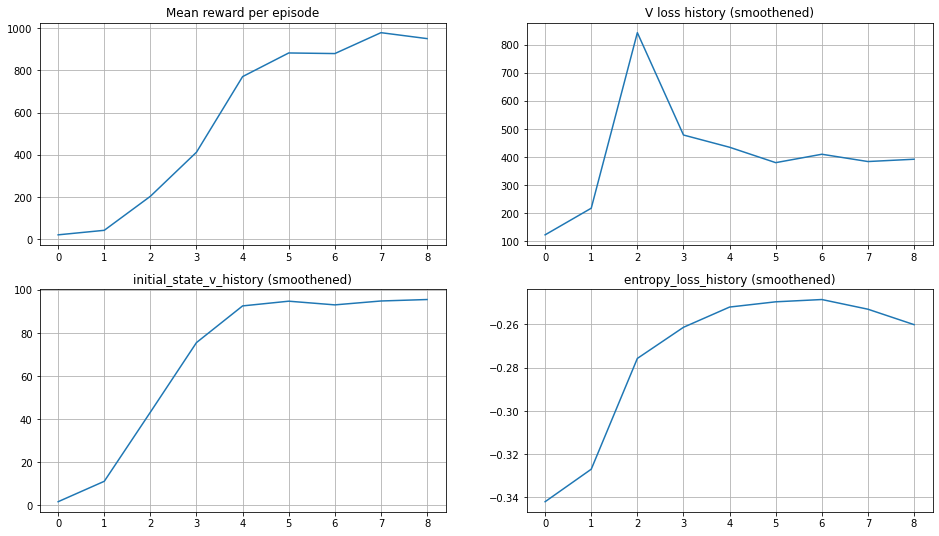

KeyboardInterrupt: 

In [30]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import utils

mean_rw_history = []
v_loss_history = []
entropy_loss_history = []
initial_state_v_history = []

for i in range(10):
    rewards, v_initial, entropy_losses, v_losses = zip( *[train_on_session(*generate_session(env), entropy_coef=1.) for _ in range(10**2)] )   # generate new sessions
    
    mean_rw_history.append(np.mean(rewards))
    entropy_loss_history.append(np.mean(entropy_losses))
    v_loss_history.append(np.mean(v_losses))
    initial_state_v_history.append(np.mean(v_initial))
    
    
    clear_output(True)
    print("step:%i" % (i))

    plt.figure(figsize=[16, 9])

    plt.subplot(2, 2, 1)
    plt.title("Mean reward per episode")
    plt.plot(mean_rw_history)
    plt.grid()

    assert not np.isnan(v_loss_history[-1])
    plt.subplot(2, 2, 2)
    plt.title("V loss history (smoothened)")
    plt.plot(v_loss_history)
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.title("initial_state_v_history (smoothened)")
    plt.plot(initial_state_v_history)
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.title("entropy_loss_history (smoothened)")
    plt.plot(entropy_loss_history)
    plt.grid()

    plt.show()
    
    if np.mean(rewards) >= 900:
        print("You Win!")  # but you can train even further
        break

### Results & video

In [31]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make(env_name), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(1)]

In [32]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))